In [105]:
# Import necessary libraries
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [67]:
# Load your dataset
df = pd.read_csv("C:\\Users\\LENOVO\\.jupyter\\Loyal Guru Project\\Customer Data\\data.csv.zip", encoding='ISO-8859-1')

# Convert to date time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Connect to SQLite (creates file if it doesn't exist)
conn = sqlite3.connect('customer_data.db')

# Save DataFrame to SQL table named 'transactions'
df.to_sql('transactions', conn, if_exists='replace', index=False)

conn.close()

In [79]:
conn = sqlite3.connect('customer_data.db')

# Get max InvoiceDate
max_date_query = "SELECT MAX(InvoiceDate) as max_date FROM transactions"
max_date = pd.read_sql_query(max_date_query, conn)["max_date"][0]

# Use that max_date directly in your SQL query
query = f'''
SELECT
        CustomerID,
        julianday('{max_date}') - julianday(MAX(InvoiceDate)) AS Recency,
        COUNT(DISTINCT InvoiceNo) AS Frequency,
        SUM(Quantity * UnitPrice) AS Monetary
    FROM transactions
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID
    HAVING MAX(InvoiceDate) IS NOT NULL AND SUM(Quantity * UnitPrice) > 0
'''

# Step 3: Execute and load into DataFrame
rfm_df = pd.read_sql_query(query, conn)

# Optionally, preview the result
print(rfm_df.head())

   CustomerID     Recency  Frequency  Monetary
0     12347.0    1.873611          7   4310.00
1     12348.0   74.984028          4   1797.24
2     12349.0   18.124306          1   1757.55
3     12350.0  309.867361          1    334.40
4     12352.0   35.925694         11   1545.41


In [81]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df_clean[['Recency', 'Frequency', 'Monetary']])

In [83]:
# Convert back to DataFrame for easier handling
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print(rfm_scaled_df.head())

    Recency  Frequency  Monetary
0 -0.887717   0.200326  0.288421
1 -0.150342  -0.119224 -0.015541
2 -0.723817  -0.438773 -0.020342
3  2.218640  -0.438773 -0.192497
4 -0.544276   0.626393 -0.046004


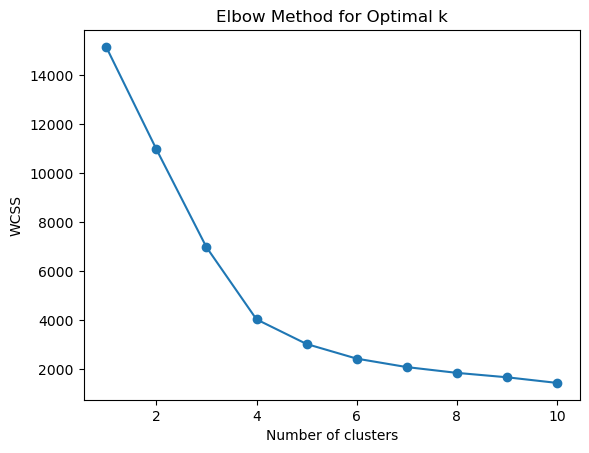

In [93]:
# Elbow method to find optimal cluster number
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

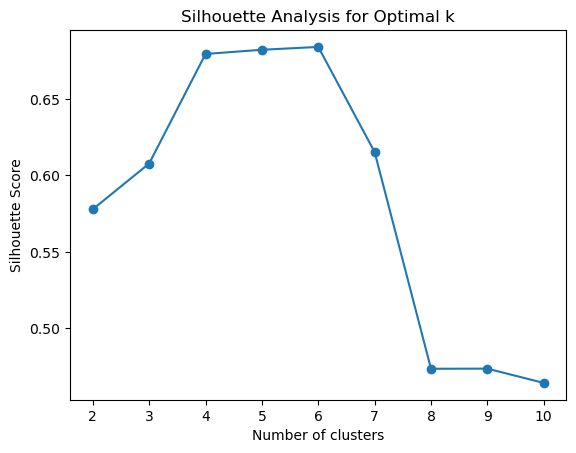

In [97]:
# Silhouette score
sil_scores = []
for i in range(2, 11):  # silhouette score needs at least 2 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [109]:
# Choose number of clusters
k = 5  # you can experiment with this number

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(rfm_scaled_df)

# Add cluster labels to your DataFrame
rfm_scaled_df['Cluster'] = kmeans.labels_

print(rfm_scaled_df['Cluster'].value_counts())

Cluster
0    3058
1    1055
3     190
2      11
4       3
Name: count, dtype: int64


In [111]:
# Join clusters with original (unscaled) RFM data to interpret clusters easily
rfm_df_clean['Cluster'] = kmeans.labels_

cluster_summary = rfm_df_clean.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

print(cluster_summary)

        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          41.7       4.4    1332.5  3058
1         245.1       1.9     490.4  1055
2           7.4     116.3   69944.1    11
3          10.2      27.6   11727.7   190
4           3.0      64.7  241136.6     3


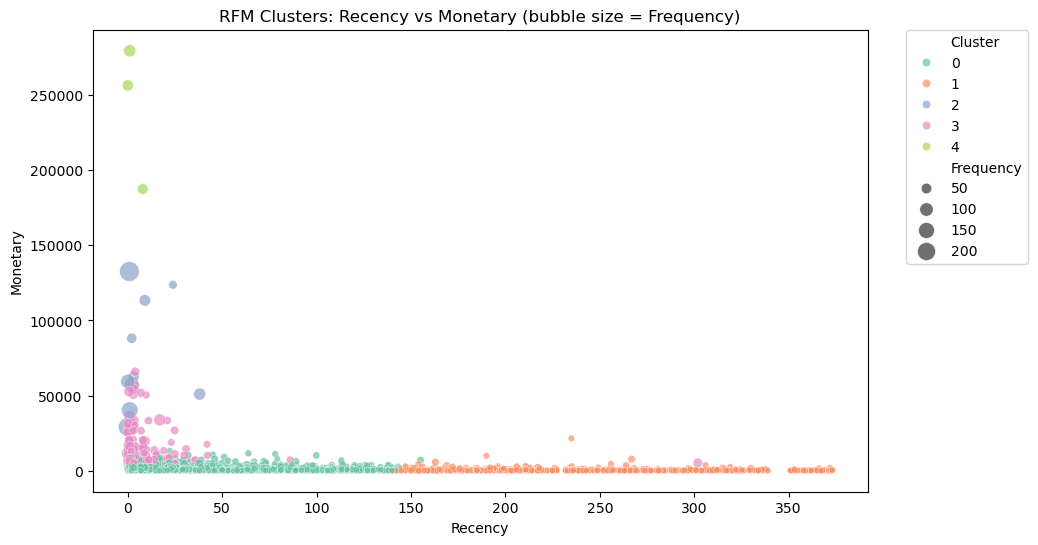

In [117]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Recency', y='Monetary', size='Frequency', sizes=(20, 200),
    hue='Cluster', data=rfm_df_clean, palette='Set2', alpha=0.7
)
plt.title('RFM Clusters: Recency vs Monetary (bubble size = Frequency)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()